In [14]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pathlib import Path
import json
import sys
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Add src to path for imports
sys.path.append('../../src')

# Configure visualization settings
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

print("Libraries imported successfully!")


Libraries imported successfully!


In [6]:
# Load the cleaned dataset from EDA
interim_path = Path('../../data/interim/Telco-Customer-Churn-Cleaned.csv')

if interim_path.exists():
    df = pd.read_csv(interim_path)
    print(f"Loaded cleaned dataset from {interim_path}")
else:
    # Fallback to raw data with basic cleaning
    raw_path = Path('../../data/raw/Telco-Customer-Churn.csv')
    df = pd.read_csv(raw_path)
    print(f"Interim file not found, loading raw data from {raw_path}")
    
    # Basic cleaning
    df['TotalCharges'] = df['TotalCharges'].replace(' ', np.nan)
    df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

print(f"Dataset shape: {df.shape}")
print("Target variable: Churn")
print(f"Churn rate: {(df['Churn'] == 'Yes').mean():.1%}")
print(f"Missing values: {df.isnull().sum().sum()}")

# Display basic info
print("\nDataset Overview:")
print(f"- Customers: {len(df):,}")
print(f"- Features: {df.shape[1] - 1}")
print(f"- Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Show first few rows
print("\nFirst 3 rows:")
print(df.head(3))


Loaded cleaned dataset from ../../data/interim/Telco-Customer-Churn-Cleaned.csv
Dataset shape: (7043, 21)
Target variable: Churn
Churn rate: 26.5%
Missing values: 11

Dataset Overview:
- Customers: 7,043
- Features: 20
- Memory usage: 7.42 MB

First 3 rows:
   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity OnlineBackup  \
0  No phone service             DSL             No          Yes   
1                No             DSL            Yes           No   
2                No             DSL            Yes          Yes   

  DeviceProtection TechSupport StreamingTV StreamingMovies        Contract  \
0               No          No          No              No  Month-to-month

In [7]:
# Create a copy for feature engineering
df_features = df.copy()

print("CREATING DERIVED FEATURES")
print("=" * 40)

# 1. Tenure Categories (based on EDA insights)
def categorize_tenure(tenure):
    if tenure <= 12:
        return 'New'  # 0-12 months
    elif tenure <= 24:
        return 'Medium'  # 13-24 months
    elif tenure <= 48:
        return 'Long'  # 25-48 months
    else:
        return 'Very_Long'  # 49+ months

df_features['tenure_category'] = df_features['tenure'].apply(categorize_tenure)
print("Created tenure_category")
print(f"   Distribution: {df_features['tenure_category'].value_counts().to_dict()}")

# 2. Monthly Charges Categories
def categorize_monthly_charges(charges):
    if charges < 35:
        return 'Low'
    elif charges <= 65:
        return 'Medium'
    else:
        return 'High'

df_features['monthly_charges_category'] = df_features['MonthlyCharges'].apply(categorize_monthly_charges)
print("\nCreated monthly_charges_category")
print(f"   Distribution: {df_features['monthly_charges_category'].value_counts().to_dict()}")

# 3. Total Services Count
service_columns = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 
                'TechSupport', 'StreamingTV', 'StreamingMovies']

# Count 'Yes' responses for services
df_features['total_services'] = 0
for col in service_columns:
    df_features['total_services'] += (df_features[col] == 'Yes').astype(int)

print("\nCreated total_services")
print(f"   Range: {df_features['total_services'].min()} to {df_features['total_services'].max()}")
print(f"   Distribution: {df_features['total_services'].value_counts().to_dict()}")

# 4. Average Monthly Spend (handle missing TotalCharges)
df_features['avg_monthly_spend'] = np.where(
    (df_features['tenure'] > 0) & (df_features['TotalCharges'].notna()),
    df_features['TotalCharges'] / df_features['tenure'],
    df_features['MonthlyCharges']  # Fallback to current monthly charges
)

print("\nCreated avg_monthly_spend")
print(f"   Range: ${df_features['avg_monthly_spend'].min():.2f} to ${df_features['avg_monthly_spend'].max():.2f}")

# 5. Payment Risk Indicator (based on EDA insights)
payment_risk_map = {
    'Electronic check': 'High',
    'Mailed check': 'Medium', 
    'Bank transfer (automatic)': 'Low',
    'Credit card (automatic)': 'Low'
}

df_features['payment_risk'] = df_features['PaymentMethod'].replace(payment_risk_map)
print("\nCreated payment_risk")
print(f"   Distribution: {df_features['payment_risk'].value_counts().to_dict()}")

# 6. Has Internet Services
df_features['has_internet'] = (df_features['InternetService'] != 'No').astype(int)
print("\nCreated has_internet")
print(f"   Distribution: {df_features['has_internet'].value_counts().to_dict()}")

# 7. Senior Citizen Label (for easier analysis)
df_features['senior_citizen_label'] = df_features['SeniorCitizen'].replace({0: 'No', 1: 'Yes'})

# 8. Contract Risk Score (month-to-month is highest risk)
contract_risk_map = {
    'Month-to-month': 3,
    'One year': 2,
    'Two year': 1
}
df_features['contract_risk_score'] = df_features['Contract'].replace(contract_risk_map)

print("\nCreated contract_risk_score")
print(f"   Distribution: {df_features['contract_risk_score'].value_counts().to_dict()}")

print("\nFEATURE ENGINEERING SUMMARY:")
print(f"Original features: {df.shape[1]}")
print("New features created: 7")
print(f"Total features: {df_features.shape[1]}")
print(f"New feature names: {['tenure_category', 'monthly_charges_category', 'total_services', 'avg_monthly_spend', 'payment_risk', 'has_internet', 'contract_risk_score']}")


CREATING DERIVED FEATURES
Created tenure_category
   Distribution: {'Very_Long': 2239, 'New': 2186, 'Long': 1594, 'Medium': 1024}

Created monthly_charges_category
   Distribution: {'High': 3899, 'Low': 1731, 'Medium': 1413}

Created total_services
   Range: 0 to 6
   Distribution: {0: 2219, 3: 1118, 2: 1033, 1: 966, 4: 852, 5: 571, 6: 284}

Created avg_monthly_spend
   Range: $13.78 to $121.40

Created payment_risk
   Distribution: {'Low': 3066, 'High': 2365, 'Medium': 1612}

Created has_internet
   Distribution: {1: 5517, 0: 1526}

Created contract_risk_score
   Distribution: {3: 3875, 1: 1695, 2: 1473}

FEATURE ENGINEERING SUMMARY:
Original features: 21
New features created: 7
Total features: 29
New feature names: ['tenure_category', 'monthly_charges_category', 'total_services', 'avg_monthly_spend', 'payment_risk', 'has_internet', 'contract_risk_score']


CHURN ANALYSIS FOR NEW FEATURES

TENURE_CATEGORY:
   Long: 20.4% churn rate (1,594 customers)
   Medium: 28.7% churn rate (1,024 customers)
   New: 47.4% churn rate (2,186 customers)
   Very_Long: 9.5% churn rate (2,239 customers)

MONTHLY_CHARGES_CATEGORY:
   High: 34.7% churn rate (3,899 customers)
   Low: 10.9% churn rate (1,731 customers)
   Medium: 23.1% churn rate (1,413 customers)

TOTAL_SERVICES:
   0: 21.4% churn rate (2,219 customers)
   1: 45.8% churn rate (966 customers)
   2: 35.8% churn rate (1,033 customers)
   3: 27.4% churn rate (1,118 customers)
   4: 22.3% churn rate (852 customers)
   5: 12.4% churn rate (571 customers)
   6: 5.3% churn rate (284 customers)

PAYMENT_RISK:
   High: 45.3% churn rate (2,365 customers)
   Low: 16.0% churn rate (3,066 customers)
   Medium: 19.1% churn rate (1,612 customers)

HAS_INTERNET:
   0: 7.4% churn rate (1,526 customers)
   1: 31.8% churn rate (5,517 customers)

CONTRACT_RISK_SCORE:
   1: 2.8% churn rate (1,695 customers)
   2: 11

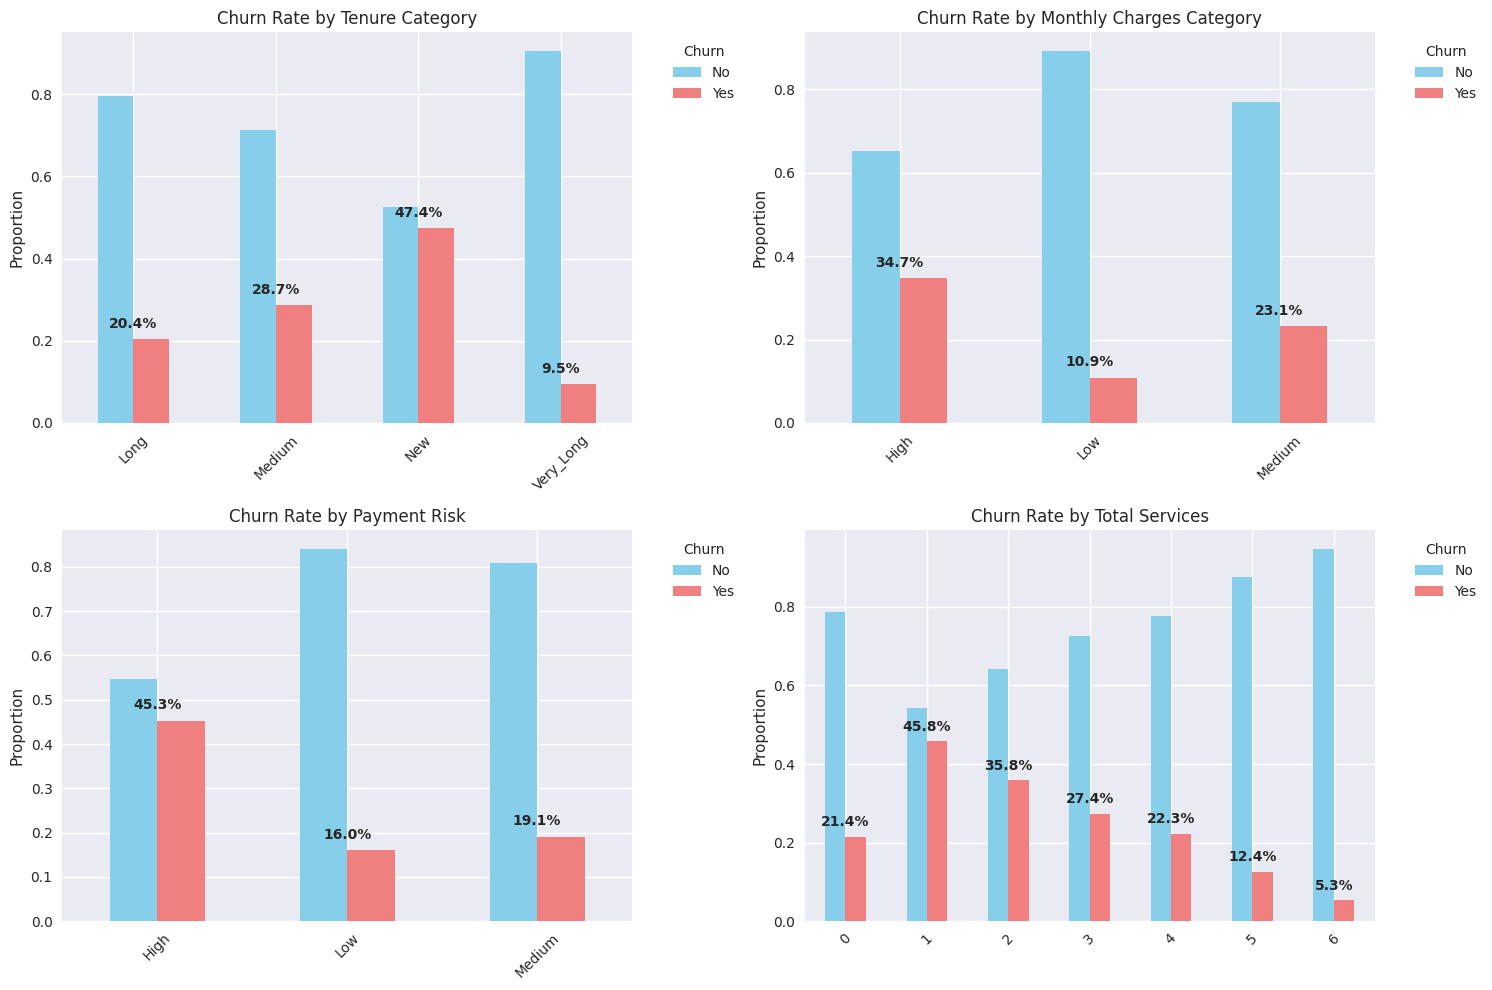


New features show clear differentiation in churn rates!


In [8]:
# Analyze churn rates for new features
print("CHURN ANALYSIS FOR NEW FEATURES")
print("=" * 45)

new_features = ['tenure_category', 'monthly_charges_category', 'total_services', 
            'payment_risk', 'has_internet', 'contract_risk_score']

for feature in new_features:
    print(f"\n{feature.upper()}:")
    if df_features[feature].dtype == 'object':
        # Categorical feature
        churn_by_category = df_features.groupby(feature)['Churn'].apply(lambda x: (x == 'Yes').mean())
        for category, rate in churn_by_category.items():
            count = len(df_features[df_features[feature] == category])
            print(f"   {category}: {rate:.1%} churn rate ({count:,} customers)")
    else:
        # Numerical feature
        churn_by_value = df_features.groupby(feature)['Churn'].apply(lambda x: (x == 'Yes').mean())
        for value, rate in churn_by_value.items():
            count = len(df_features[df_features[feature] == value])
            print(f"   {value}: {rate:.1%} churn rate ({count:,} customers)")

# Quick visualization of key new features
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.ravel()

categorical_features = ['tenure_category', 'monthly_charges_category', 'payment_risk', 'total_services']

for i, feature in enumerate(categorical_features):
    ax = axes[i]
    
    # Create crosstab for proportions
    crosstab = pd.crosstab(df_features[feature], df_features['Churn'], normalize='index')
    
    # Plot
    crosstab.plot(kind='bar', ax=ax, color=['skyblue', 'lightcoral'])
    ax.set_title(f'Churn Rate by {feature.replace("_", " ").title()}')
    ax.set_xlabel('')
    ax.set_ylabel('Proportion')
    ax.legend(title='Churn', bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.tick_params(axis='x', rotation=45)
    
    # Add percentage labels
    for j, (category, rates) in enumerate(crosstab.iterrows()):
        churn_rate = rates['Yes']
        ax.text(j, churn_rate + 0.02, f'{churn_rate:.1%}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print("\nNew features show clear differentiation in churn rates!")


In [10]:
# Create encoded dataset
df_encoded = df_features.copy()

print("FEATURE ENCODING")
print("=" * 25)

# 1. Target Variable Encoding
df_encoded['Churn_encoded'] = (df_encoded['Churn'] == 'Yes').astype(int)
print("Encoded target variable: Churn -> Churn_encoded (0/1)")

# 2. Binary Features (Yes/No -> 1/0)
binary_features = ['Partner', 'Dependents', 'PhoneService', 'PaperlessBilling']

for feature in binary_features:
    df_encoded[f'{feature}_encoded'] = (df_encoded[feature] == 'Yes').astype(int)
    print(f"Encoded {feature}: Yes/No -> 1/0")

# 3. Ordinal Features (with natural ordering)
# Contract (Month-to-month < One year < Two year in terms of commitment)
contract_mapping = {'Month-to-month': 0, 'One year': 1, 'Two year': 2}
df_encoded['Contract_encoded'] = df_encoded['Contract'].replace(contract_mapping)

# Tenure Category (New < Medium < Long < Very_Long)
tenure_mapping = {'New': 0, 'Medium': 1, 'Long': 2, 'Very_Long': 3}
df_encoded['tenure_category_encoded'] = df_encoded['tenure_category'].replace(tenure_mapping)

# Monthly Charges Category (Low < Medium < High)
charges_mapping = {'Low': 0, 'Medium': 1, 'High': 2}
df_encoded['monthly_charges_category_encoded'] = df_encoded['monthly_charges_category'].replace(charges_mapping)

# Payment Risk (Low < Medium < High)
risk_mapping = {'Low': 0, 'Medium': 1, 'High': 2}
df_encoded['payment_risk_encoded'] = df_encoded['payment_risk'].replace(risk_mapping)

print("Encoded ordinal features: Contract, tenure_category, monthly_charges_category, payment_risk")

# 4. Multi-class Categorical Features (One-Hot Encoding)
categorical_features = ['gender', 'MultipleLines', 'InternetService', 'OnlineSecurity', 
                    'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 
                    'StreamingMovies', 'PaymentMethod']

print(f"\nOne-Hot Encoding for {len(categorical_features)} categorical features:")

for feature in categorical_features:
    # Get unique values
    unique_values = df_encoded[feature].unique()
    print(f"   {feature}: {len(unique_values)} categories -> {len(unique_values)} dummy variables")
    
    # Create dummy variables
    dummies = pd.get_dummies(df_encoded[feature], prefix=feature, dtype=int)
    
    # Add to dataframe
    df_encoded = pd.concat([df_encoded, dummies], axis=1)

print("\nOne-hot encoding completed")

# 5. Numerical Features (already in proper format)
numerical_features = ['tenure', 'MonthlyCharges', 'TotalCharges', 'SeniorCitizen',
                    'total_services', 'avg_monthly_spend', 'has_internet', 'contract_risk_score']

print(f"\nNumerical features ready: {len(numerical_features)} features")
for feature in numerical_features:
    if df_encoded[feature].isnull().sum() > 0:
        print(f"{feature}: {df_encoded[feature].isnull().sum()} missing values")
    else:
        print(f"{feature}: No missing values")

# Handle missing values in TotalCharges
missing_count = df_encoded['TotalCharges'].isnull().sum()
if missing_count > 0:
    # Fill with overall median (simple and effective)
    print(f"\nHandling {missing_count} missing TotalCharges values")
    overall_median = df_encoded['TotalCharges'].median()
    df_encoded['TotalCharges'] = df_encoded['TotalCharges'].fillna(overall_median)
    print("TotalCharges missing values filled with overall median")

print("\nENCODING SUMMARY:")
print(f"Original shape: {df_features.shape}")
print(f"Encoded shape: {df_encoded.shape}")
print(f"New columns added: {df_encoded.shape[1] - df_features.shape[1]}")
print(f"Missing values: {df_encoded.isnull().sum().sum()}")


FEATURE ENCODING
Encoded target variable: Churn -> Churn_encoded (0/1)
Encoded Partner: Yes/No -> 1/0
Encoded Dependents: Yes/No -> 1/0
Encoded PhoneService: Yes/No -> 1/0
Encoded PaperlessBilling: Yes/No -> 1/0
Encoded ordinal features: Contract, tenure_category, monthly_charges_category, payment_risk

One-Hot Encoding for 10 categorical features:
   gender: 2 categories -> 2 dummy variables
   MultipleLines: 3 categories -> 3 dummy variables
   InternetService: 3 categories -> 3 dummy variables
   OnlineSecurity: 3 categories -> 3 dummy variables
   OnlineBackup: 3 categories -> 3 dummy variables
   DeviceProtection: 3 categories -> 3 dummy variables
   TechSupport: 3 categories -> 3 dummy variables
   StreamingTV: 3 categories -> 3 dummy variables
   StreamingMovies: 3 categories -> 3 dummy variables
   PaymentMethod: 4 categories -> 4 dummy variables

One-hot encoding completed

Numerical features ready: 8 features
tenure: No missing values
MonthlyCharges: No missing values
TotalCh

In [11]:
# Prepare feature matrix for analysis
print("FEATURE SELECTION ANALYSIS")
print("=" * 35)

# Identify all encoded/processed features
original_categorical = ['customerID', 'gender', 'Partner', 'Dependents', 'PhoneService',
                    'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
                    'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
                    'Contract', 'PaperlessBilling', 'PaymentMethod', 'Churn']

# New engineered features (categorical)
new_categorical = ['tenure_category', 'monthly_charges_category', 'payment_risk', 'senior_citizen_label']

# All columns to exclude from feature matrix
exclude_columns = original_categorical + new_categorical

# Get all remaining columns as features (encoded versions + numerical)
feature_columns = [col for col in df_encoded.columns if col not in exclude_columns]

print(f"Total available features: {len(feature_columns)}")
print(f"Numerical features: {len([col for col in feature_columns if not col.startswith(('gender_', 'MultipleLines_', 'InternetService_', 'OnlineSecurity_', 'OnlineBackup_', 'DeviceProtection_', 'TechSupport_', 'StreamingTV_', 'StreamingMovies_', 'PaymentMethod_'))])}")
print(f"Dummy variables: {len([col for col in feature_columns if col.startswith(('gender_', 'MultipleLines_', 'InternetService_', 'OnlineSecurity_', 'OnlineBackup_', 'DeviceProtection_', 'TechSupport_', 'StreamingTV_', 'StreamingMovies_', 'PaymentMethod_'))])}")

# Create feature matrix
X = df_encoded[feature_columns].copy()
y = df_encoded['Churn_encoded'].copy()

print(f"\nFeature Matrix Shape: {X.shape}")
print(f"Target Distribution: {y.value_counts().to_dict()}")

# Check for any remaining missing values
missing_features = X.isnull().sum()
if missing_features.sum() > 0:
    print("\nFeatures with missing values:")
    for feature, count in missing_features[missing_features > 0].items():
        print(f"   {feature}: {count} missing values")
else:
    print("\nNo missing values in feature matrix")

# Basic correlation analysis
print("\nCORRELATION ANALYSIS")
print("=" * 25)

# Correlation with target
target_correlations = X.corrwith(y).abs().sort_values(ascending=False)

print("Top 15 features by correlation with churn:")
for i, (feature, correlation) in enumerate(target_correlations.head(15).items(), 1):
    print(f"   {i:2d}. {feature:35s}: {correlation:.3f}")

# Feature correlation matrix (for multicollinearity check)
print("\nChecking for multicollinearity...")
numerical_features_encoded = ['tenure', 'MonthlyCharges', 'TotalCharges', 'SeniorCitizen',
                            'total_services', 'avg_monthly_spend', 'has_internet', 'contract_risk_score',
                            'Contract_encoded', 'tenure_category_encoded', 'monthly_charges_category_encoded', 
                            'payment_risk_encoded']

# Get correlations between numerical features
if len(numerical_features_encoded) > 1:
    numerical_corr = X[numerical_features_encoded].corr(method='pearson')
    
    # Find high correlations (> 0.8)
    high_corr_pairs = []
    for i in range(len(numerical_corr.columns)):
        for j in range(i+1, len(numerical_corr.columns)):
            corr_val = abs(numerical_corr.iloc[i, j])
            if corr_val > 0.8:
                high_corr_pairs.append((numerical_corr.columns[i], numerical_corr.columns[j], corr_val))
    
    if high_corr_pairs:
        print("High correlation pairs (> 0.8):")
        for feat1, feat2, corr in high_corr_pairs:
            print(f"   {feat1} <-> {feat2}: {corr:.3f}")
    else:
        print("No high correlations (> 0.8) found between numerical features")

print(f"\nReady for feature selection with {X.shape[1]} features!")


FEATURE SELECTION ANALYSIS
Total available features: 47
Numerical features: 17
Dummy variables: 30

Feature Matrix Shape: (7043, 47)
Target Distribution: {0: 5174, 1: 1869}

No missing values in feature matrix

CORRELATION ANALYSIS
Top 15 features by correlation with churn:
    1. Churn_encoded                      : 1.000
    2. contract_risk_score                : 0.397
    3. Contract_encoded                   : 0.397
    4. tenure                             : 0.352
    5. tenure_category_encoded            : 0.345
    6. OnlineSecurity_No                  : 0.343
    7. TechSupport_No                     : 0.337
    8. InternetService_Fiber optic        : 0.308
    9. PaymentMethod_Electronic check     : 0.302
   10. payment_risk_encoded               : 0.283
   11. OnlineBackup_No                    : 0.268
   12. DeviceProtection_No                : 0.252
   13. has_internet                       : 0.228
   14. InternetService_No                 : 0.228
   15. DeviceProtection_N

In [12]:
# Feature scaling for machine learning
print("FEATURE SCALING")
print("=" * 20)

# Identify features that need scaling (continuous numerical features)
scaling_features = ['tenure', 'MonthlyCharges', 'TotalCharges', 'avg_monthly_spend']

print(f"Features requiring scaling: {scaling_features}")

# Create scaled version of the feature matrix
X_scaled = X.copy()

# Use StandardScaler for numerical features
scaler = StandardScaler()
X_scaled[scaling_features] = scaler.fit_transform(X[scaling_features])
print("Applied StandardScaler to numerical features")

# Display scaling statistics
print("\nScaling Statistics:")
for feature in scaling_features:
    original_mean = X[feature].mean()
    original_std = X[feature].std()
    scaled_mean = X_scaled[feature].mean()
    scaled_std = X_scaled[feature].std()
    print(f"   {feature}:")
    print(f"      Original: μ={original_mean:.2f}, σ={original_std:.2f}")
    print(f"      Scaled:   μ={scaled_mean:.2f}, σ={scaled_std:.2f}")

print("\nFINAL DATASET SUMMARY")
print("=" * 30)
print(f"Dataset shape: {X_scaled.shape}")
print(f"Target shape: {y.shape}")
print(f"Features: {X_scaled.shape[1]}")
print(f"Samples: {X_scaled.shape[0]}")
print(f"Class distribution: {y.value_counts().to_dict()}")
print("Feature types:")
print(f"   - Numerical (scaled): {len(scaling_features)}")
print(f"   - Encoded ordinal: {len([col for col in X_scaled.columns if col.endswith('_encoded')])}")
print(f"   - Binary/dummy: {len([col for col in X_scaled.columns if col.startswith(('gender_', 'MultipleLines_', 'InternetService_', 'OnlineSecurity_', 'OnlineBackup_', 'DeviceProtection_', 'TechSupport_', 'StreamingTV_', 'StreamingMovies_', 'PaymentMethod_')) or col.endswith('_encoded') and not col in ['Contract_encoded', 'tenure_category_encoded', 'monthly_charges_category_encoded', 'payment_risk_encoded']])}")

# Show feature importance rankings
print("\nTOP 20 FEATURES BY CORRELATION:")
for i, (feature, correlation) in enumerate(target_correlations.head(20).items(), 1):
    feature_type = "Numerical" if feature in scaling_features else ("Ordinal" if feature.endswith('_encoded') else "Binary")
    print(f"   {i:2d}. {feature_type} {feature[:45]:45s}: {correlation:.3f}")

print("\nDataset ready for machine learning!")


FEATURE SCALING
Features requiring scaling: ['tenure', 'MonthlyCharges', 'TotalCharges', 'avg_monthly_spend']
Applied StandardScaler to numerical features

Scaling Statistics:
   tenure:
      Original: μ=32.37, σ=24.56
      Scaled:   μ=-0.00, σ=1.00
   MonthlyCharges:
      Original: μ=64.76, σ=30.09
      Scaled:   μ=-0.00, σ=1.00
   TotalCharges:
      Original: μ=2281.92, σ=2265.27
      Scaled:   μ=-0.00, σ=1.00
   avg_monthly_spend:
      Original: μ=64.76, σ=30.19
      Scaled:   μ=0.00, σ=1.00

FINAL DATASET SUMMARY
Dataset shape: (7043, 47)
Target shape: (7043,)
Features: 47
Samples: 7043
Class distribution: {0: 5174, 1: 1869}
Feature types:
   - Numerical (scaled): 4
   - Encoded ordinal: 9
   - Binary/dummy: 35

TOP 20 FEATURES BY CORRELATION:
    1. Ordinal Churn_encoded                                : 1.000
    2. Binary contract_risk_score                          : 0.397
    3. Ordinal Contract_encoded                             : 0.397
    4. Numerical tenure        

In [15]:
# Save processed datasets for modeling
print("SAVING PROCESSED DATASETS")
print("=" * 35)

# Ensure interim directory exists
interim_dir = Path('../../data/interim')
interim_dir.mkdir(parents=True, exist_ok=True)

# Save feature engineered dataset
features_path = interim_dir / 'telco_features_engineered.csv'
df_features.to_csv(features_path, index=False)
print(f"Saved feature engineered dataset: {features_path}")

# Save fully encoded dataset
encoded_path = interim_dir / 'telco_fully_encoded.csv'
df_encoded.to_csv(encoded_path, index=False)
print(f"Saved fully encoded dataset: {encoded_path}")

# Save ML-ready datasets
ml_features_path = interim_dir / 'telco_ml_features.csv'
ml_target_path = interim_dir / 'telco_ml_target.csv'
ml_scaled_path = interim_dir / 'telco_ml_features_scaled.csv'

X.to_csv(ml_features_path, index=False)
y.to_csv(ml_target_path, index=False)
X_scaled.to_csv(ml_scaled_path, index=False)

print(f"Saved ML-ready features: {ml_features_path}")
print(f"Saved ML-ready target: {ml_target_path}")
print(f"Saved ML-ready scaled features: {ml_scaled_path}")

# Save feature metadata
metadata = {
    'total_features': len(feature_columns),
    'numerical_features': scaling_features,
    'encoded_features': [col for col in feature_columns if col.endswith('_encoded')],
    'dummy_features': [col for col in feature_columns if '_' in col and not col.endswith('_encoded')],
    'target_column': 'Churn_encoded',
    'class_distribution': y.value_counts().to_dict(),
    'feature_correlations': target_correlations.head(10).to_dict()
}

metadata_path = interim_dir / 'feature_metadata.json'

with open(metadata_path, 'w') as f:
    json.dump(metadata, f, indent=2)

print(f"Saved feature metadata: {metadata_path}")

print("\nAll datasets saved successfully!")
print(f"Location: {interim_dir}")
print("Files created: 6 files")
print(f"Total size: {sum(p.stat().st_size for p in interim_dir.glob('telco_*')) / 1024**2:.2f} MB")


SAVING PROCESSED DATASETS
Saved feature engineered dataset: ../../data/interim/telco_features_engineered.csv
Saved fully encoded dataset: ../../data/interim/telco_fully_encoded.csv
Saved ML-ready features: ../../data/interim/telco_ml_features.csv
Saved ML-ready target: ../../data/interim/telco_ml_target.csv
Saved ML-ready scaled features: ../../data/interim/telco_ml_features_scaled.csv
Saved feature metadata: ../../data/interim/feature_metadata.json

All datasets saved successfully!
Location: ../../data/interim
Files created: 6 files
Total size: 4.83 MB
